In [1]:
import cv2
import numpy as np
from PIL import Image 
from functools import reduce
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import argparse
import datetime
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import random
from scipy.spatial import distance
from skimage.segmentation import mark_boundaries,watershed
from skimage.util import img_as_float
from skimage.morphology import disk
from skimage.filters import rank
from scipy import ndimage as ndi


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Image 2


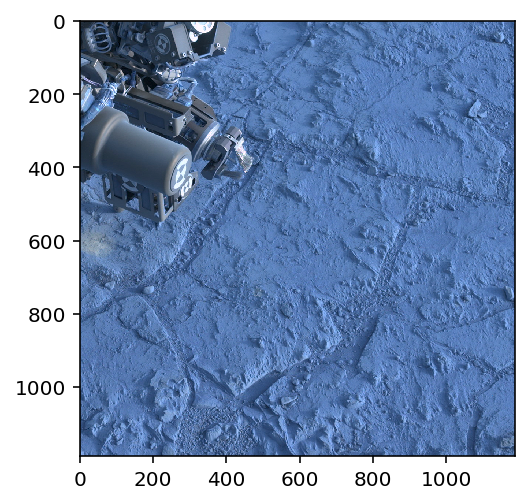

In [4]:
#input of the image
whatimg=int(input("Image"))
if whatimg==1:
    img = cv2.imread('image1.tif')
    #img=img[:,95:1500,:] 
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-15,170:width-180]
    plt.imshow(Img)
elif whatimg==2:
    img = cv2.imread('image2.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-10,10:width-10]
    plt.imshow(Img)
elif whatimg==3:
    img = cv2.imread('image3.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-15,170:width-180]
    plt.imshow(Img)
elif whatimg==4:
    img = cv2.imread('image4.tif')
    height,width=img.shape[0],img.shape[1]
    Img=img[10:height-10,10:width-10]
    plt.imshow(Img)

Color Mode(RGB,HSV,Lab,yCrCb,XYZ,LUV,YUV,gray): RGB


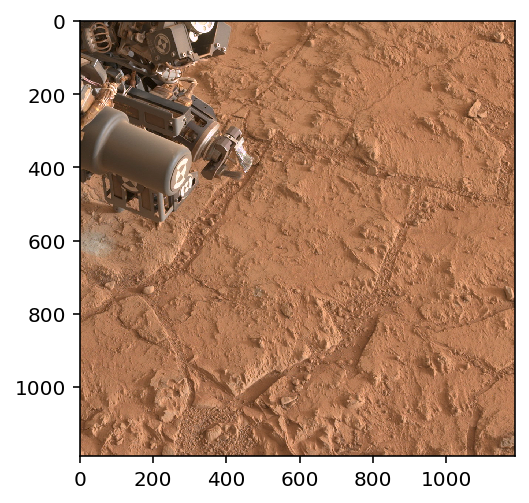

In [5]:
#color space transformation
colorsp=input("Color Mode(RGB,HSV,Lab,yCrCb,XYZ,LUV,YUV,gray):")
if colorsp=="RGB":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB )
    plt.imshow(Imag)
elif colorsp=="HSV":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2HSV )
    plt.imshow(Imag)
elif colorsp=="Lab":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2LAB )
    plt.imshow(Imag)
elif colorsp=="yCrCb":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2YCrCb)
    plt.imshow(Imag)
elif colorsp=="XYZ":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2XYZ)
    plt.imshow(Imag)   
elif colorsp=="LUV":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2LUV)
    plt.imshow(Imag)
elif colorsp=="YUV":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2YUV)
    plt.imshow(Imag)
elif colorsp=="gray":
    Imag = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)
    plt.imshow(Imag) 

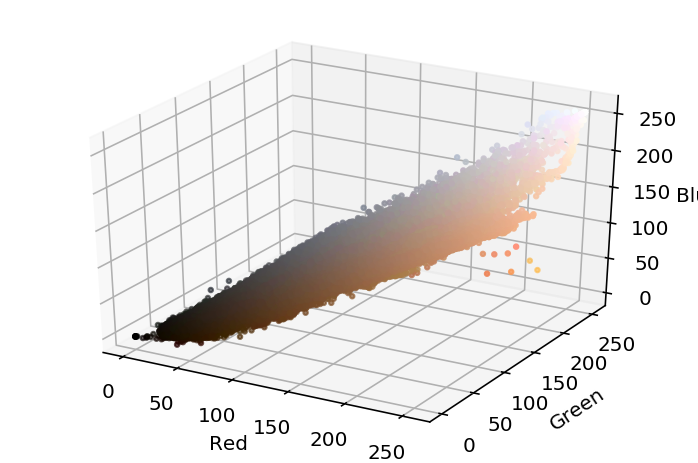

In [23]:
r, g, b = cv2.split(Imag)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = Imag.reshape((np.shape(Imag)[0]*np.shape(Imag)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()
#plt.title("R,G,B scatter plot")

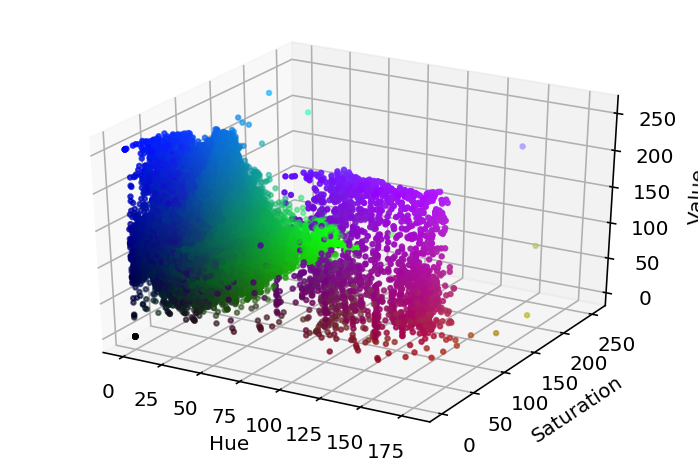

In [5]:
h, s, v = cv2.split(Imag)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = Imag.reshape((np.shape(Imag)[0]*np.shape(Imag)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()
#plt.title("H,S,V scatter plot")

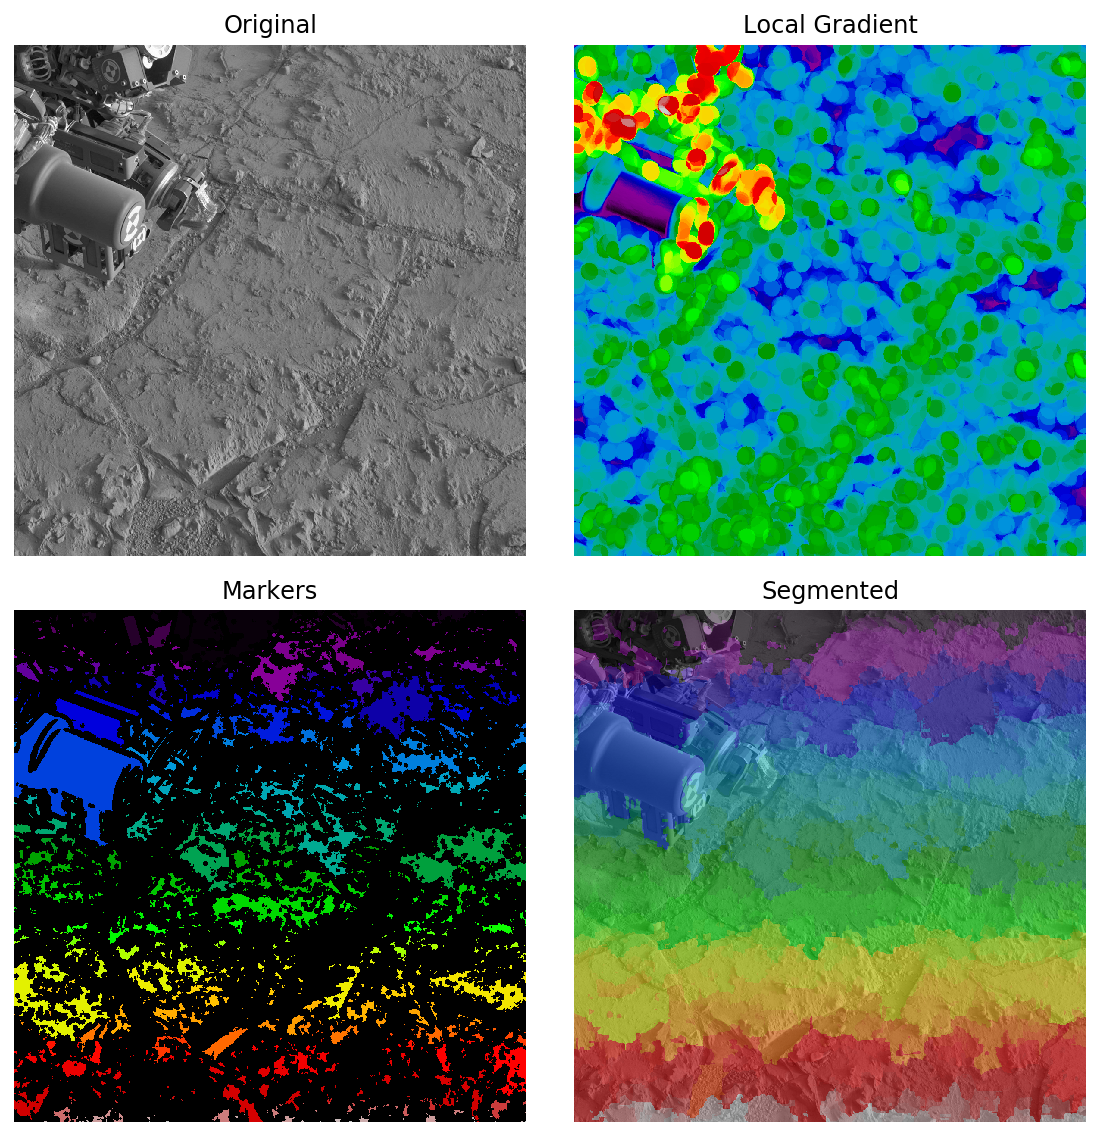

In [6]:
from scipy.ndimage import gaussian_filter
#segmentation using watershed
Image = cv2.cvtColor(Imag, cv2.COLOR_BGR2GRAY)
denoised = rank.median(Image, disk(1))# denoise image
#denoised=gaussian_filter(Image, sigma=10)

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(5)) < 30#marker is built from the regions of low gradient inside the image
markers = ndi.label(markers)[0]#using markers on the lower value ensures that the segmented objects are found;transform an image so that
#each connected image has the same labels

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(20))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(Image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(Image, cmap=plt.cm.gray)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

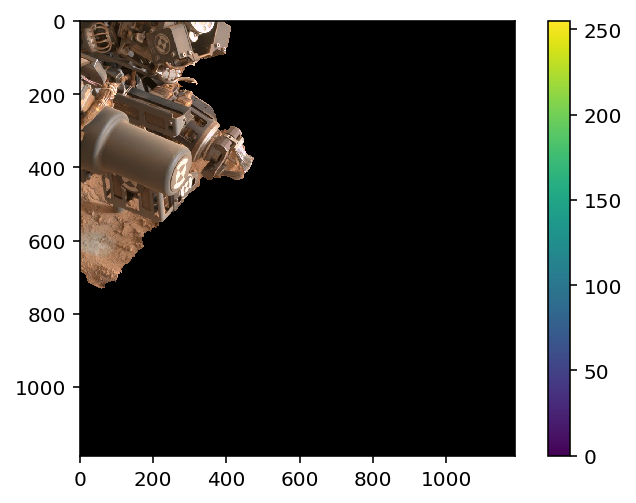

(<matplotlib.image.AxesImage at 0x7fec019c2610>,
 None)

In [12]:
#grabcut segmentation
#goal: using grabcut to extract the foreground of the image
mask = np.zeros(Imag.shape[:2],np.uint8)
bgdModel1 = np.zeros((1,65),np.float64)
fgdModel1 = np.zeros((1,65),np.float64)
#rect = (0,0,800,800)
rect = (0,0,800,800)
mask2=cv2.grabCut(Imag,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = Imag*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show() 

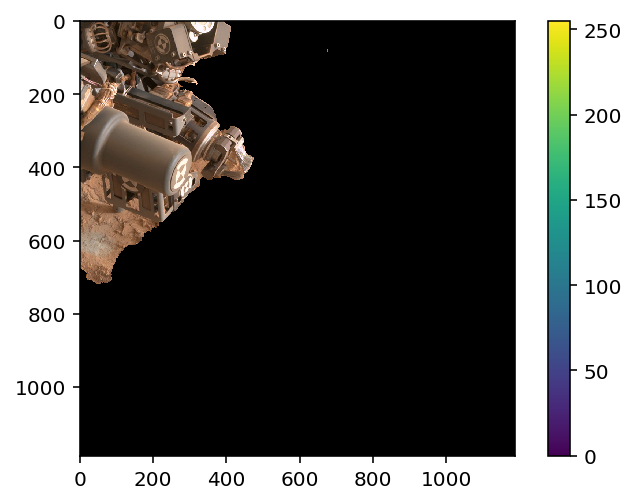

(<matplotlib.image.AxesImage at 0x7fec01a760d0>,
 None)

In [13]:
#grabcut on watershet segmentation
# newmask is the mask image I manually labelled
newmask = labels
# wherever it is marked white (sure foreground), change mask=1
# wherever it is marked black (sure background), change mask=0
mask[newmask == 0] = 0
#mask[newmask == 255] = 1
mask[newmask == 237] = 1
#mask1[newmask == 230] = 1
mask, bgdModel, fgdModel = cv2.grabCut(Imag,mask,None,bgdModel1,fgdModel1,5,cv2.GC_INIT_WITH_MASK)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
Img = Imag*mask[:,:,np.newaxis]
plt.imshow(Img),plt.colorbar(),plt.show() 